### CASA0002_Urban simulation
# London tube network analysis
---

your name

April 2021

## 1. Construct the network

### 1.1 From a shapefile to a graph:

In [364]:
pip install geopandas

In [365]:
pip install cdlib

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
import osgeo
import os

import networkx as nx
from math import sqrt

In [367]:
g_shp=nx.read_shp('underground.shp',geom_attrs=False)

In [368]:
df = nx.to_pandas_edgelist(g_shp)
df[0:10]

,source,target,toid_seq,station_1,ShpName,station_2,distance,station_2_,station_1_
0,"(-0.1571, 51.5226)","(-0.1631, 51.5225)",1,11,underground,163,416.586050,Marylebone,Baker Street
1,"(-0.1571, 51.5226)","(-0.1466, 51.5234)",2,11,underground,212,734.173636,Regent's Park,Baker Street
2,"(-0.1571, 51.5226)","(-0.17, 51.5203)",171,11,underground,83,931.211577,Edgware Road (C),Baker Street
3,"(-0.1571, 51.5226)","(-0.1439, 51.5238)",225,11,underground,104,925.826411,Great Portland Street,Baker Street
4,"(-0.1571, 51.5226)","(-0.1494, 51.5142)",197,11,underground,28,1076.607648,Bond Street,Baker Street
5,"(-0.1571, 51.5226)","(-0.174, 51.5347)",198,11,underground,249,1785.442777,St. John's Wood,Baker Street
6,"(-0.1571, 51.5226)","(-0.1803, 51.5472)",226,11,underground,94,3175.274183,Finchley Road,Baker Street
7,"(-0.1247, 51.508)","(-0.1223, 51.5074)",277,49,underground,87,179.503418,Embankment,Charing Cross
8,"(-0.1247, 51.508)","(-0.1342, 51.5098)",4,49,underground,197,689.289845,Picadilly Circus,Charing Cross
9,"(-0.1247, 51.508)","(-0.1281, 51.5113)",278,49,underground,151,436.484594,Leicester Square,Charing Cross


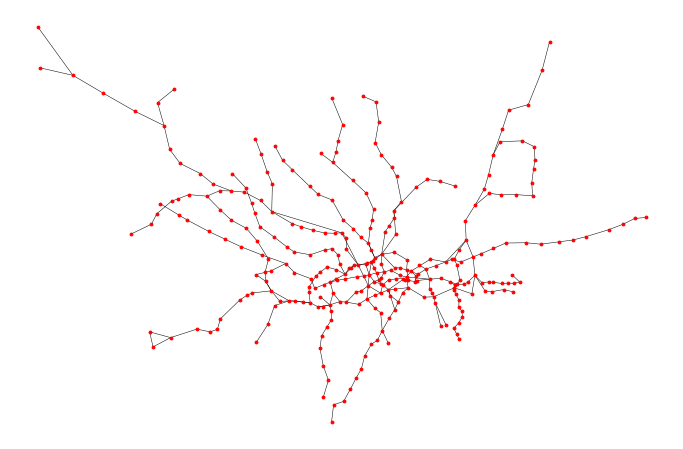

In [369]:
# Let's plot the tube network:

pos = {xy: xy for xy in g_shp.nodes()}

fig, ax = plt.subplots(figsize=(12,8))

nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
plt.axis("off")
plt.show()

In [370]:
# get the edges attributes:
list(g_shp.edges(data = True))[0]

((-0.1571, 51.5226),
 (-0.1631, 51.5225),
 {'ShpName': 'underground',
  'distance': 416.586050414,
  'station_1': 11,
  'station_1_': 'Baker Street',
  'station_2': 163,
  'station_2_': 'Marylebone',
  'toid_seq': '1'})

In [371]:
# get the nodes attributes:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {}),
 ((-0.1631, 51.5225), {}),
 ((-0.1466, 51.5234), {}),
 ((-0.1247, 51.508), {}),
 ((-0.1223, 51.5074), {}),
 ((-0.1342, 51.5098), {}),
 ((-0.1679, 51.5199), {}),
 ((-0.1755, 51.5154), {}),
 ((-0.1001, 51.4943), {}),
 ((-0.1115, 51.4991), {})]

In [372]:
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}

#for python 3.5 and greater:
nod_all = {**nod_st1, **nod_st2}

#for Python 2, (or 3.4 or lower):
# nod_all = nod_st1.copy()   
# nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# get the nodes attributes:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {'station': 'Baker Street'}),
 ((-0.1631, 51.5225), {'station': 'Marylebone'}),
 ((-0.1466, 51.5234), {'station': "Regent's Park"}),
 ((-0.1247, 51.508), {'station': 'Charing Cross'}),
 ((-0.1223, 51.5074), {'station': 'Embankment'}),
 ((-0.1342, 51.5098), {'station': 'Picadilly Circus'}),
 ((-0.1679, 51.5199), {'station': 'Edgware Road (B)'}),
 ((-0.1755, 51.5154), {'station': 'Paddington'}),
 ((-0.1001, 51.4943), {'station': 'Elephant & Castle'}),
 ((-0.1115, 51.4991), {'station': 'Lambeth North'})]

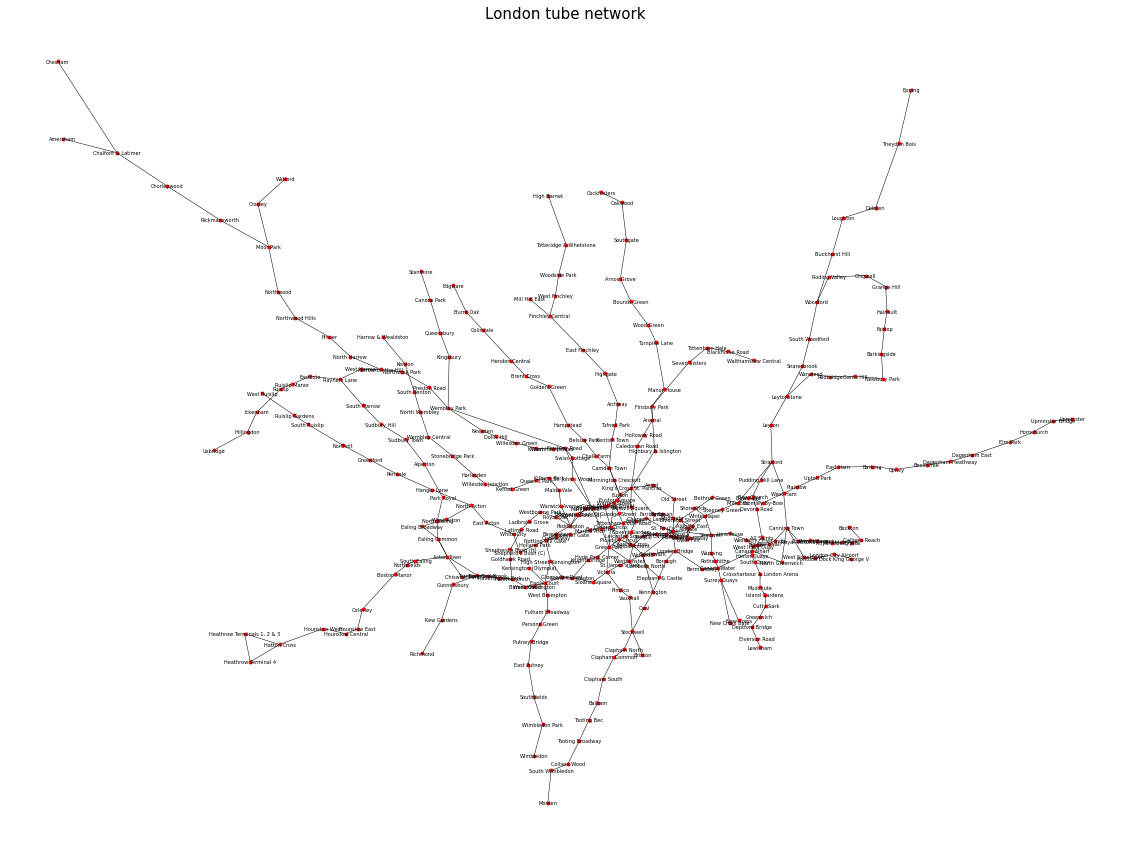

In [373]:
# We can plot the tube network with the names of the stations as labels

fig, ax = plt.subplots(figsize=(20,15))

node_labels = nx.get_node_attributes(g_shp, 'station')

nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
nx.draw_networkx_labels(g_shp,pos, node_labels, font_size=5,font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [374]:
type(g_shp)

networkx.classes.digraph.DiGraph

In [375]:
#do we want this graph to be a directed one?

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

In [376]:
print(nx.info(g_shp_un))

Name: 
Type: Graph
Number of nodes: 306
Number of edges: 353
Average degree:   2.3072


### 1.2 From csv to graph

In [377]:
# Read in the edge list file from the csv
edges_network = pd.read_csv("ODtube2017.csv")
edges_network

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9
...,...,...,...,...,...
34053,771,Woodside Park,747,Waterloo,93
34054,771,Woodside Park,755,West Brompton,0
34055,771,Woodside Park,756,West Finchley,34
34056,771,Woodside Park,761,Westminster,51


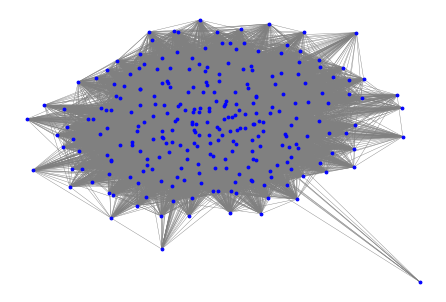

In [378]:
# Create graph object from the edge list
g_csv = nx.from_pandas_edgelist(edges_network, 'station_name', 'station_name.1',['total_wtrips'])

# Plot graph
nx.draw(g_csv,
        node_color='b',
        node_size=8,
        edge_color='gray',
        width=0.4)

## 2. Part 1 - Section 2
Present the results of the analysis in the form of concise plots clearly labelled and compared the 2 different strategies (‘sequential’ vs ‘non-sequential’) considering the results for all the centrality measures. Discuss whether the two different measures to evaluate the impact give the same results and justify whether the findings were expected.

In [379]:
# read file
source=nx.read_shp('underground.shp',geom_attrs=False)

### 2.1 Closeness Centrality (sequential)

In [380]:
g_shp = source
df = nx.to_pandas_edgelist(g_shp)
list(g_shp.edges(data = True))[0]
list(g_shp.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp, 'station')
g_shp_un = g_shp.to_undirected()

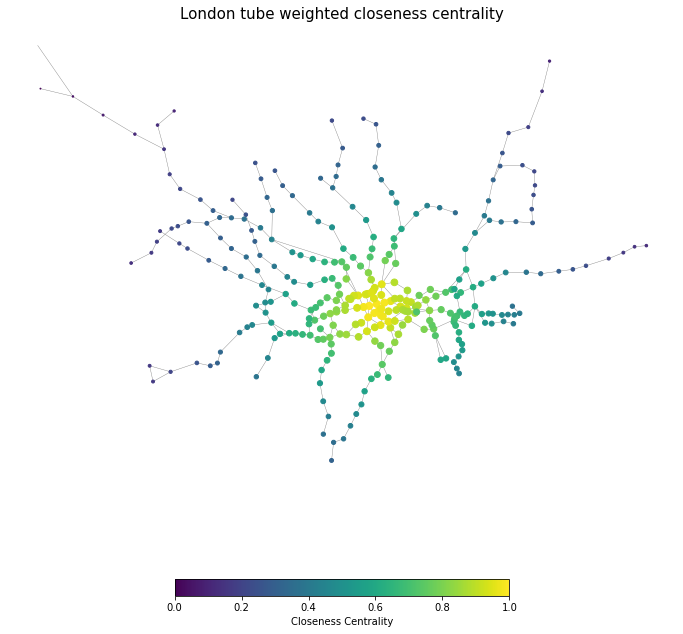

In [381]:
# graph before removing nodes

#Weighted closeness centrality: 
clos_w=nx.closeness_centrality(g_shp_un, distance='distance')
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un,clos_w,'closeness_w')

clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in g_shp_un.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in g_shp_un.nodes(data=True)]

pos = {xy: xy for xy in g_shp.nodes()}

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted closeness centrality",fontsize=15)
plt.show()

In [382]:
# remove nodes
maxclo_l = []
station_l = []
before_l = []
after_l = []

In [383]:
for j in range(0,10):

  #Weighted closeness centrality: 
  clos_w=nx.closeness_centrality(g_shp_un, distance='distance')
  # We can add these values to the nodes attributes:
  nx.set_node_attributes(g_shp_un,clos_w,'closeness_w')

  clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un.nodes(data=True)]

  #If we want to remove the node with the max value of closeness centrality:
  maxclo = [n for n in g_shp_un.nodes() if g_shp_un.nodes[n]['closeness_w'] == max(clos_w_val)]
  print(maxclo)
  remove_station = g_shp_un.nodes[maxclo[0]]['station']

  # Existing nodes:
  l1=list(g_shp_un.nodes)
  before = len(l1)
  #remove node with the
  g_shp_un.remove_nodes_from(maxclo)

  # Nodes after the removal
  l2=list(g_shp_un.nodes)
  after = len(l2)

  maxclo_l.append(maxclo)
  station_l.append(remove_station)
  before_l.append(before)
  after_l.append(after)

[(-0.1415, 51.515)]
[(-0.1342, 51.5098)]
[(-0.1254, 51.501)]
[(-0.1238, 51.5308)]
[(-0.123, 51.4723)]
[(-0.0612, 51.5194)]
[(-0.0886, 51.5133)]
[(-0.0203, 51.507)]
[(0.0056, 51.5287)]
[(-0.1223, 51.5074)]


In [384]:
dict1 = {'Max Closeness Coordinate': maxclo_l, 'Station to Remove': station_l, 'nodes before': before_l, 'nodes after': after_l} 
    
seq_clo = pd.DataFrame(dict1)
seq_clo

,Max Closeness Coordinate,Station to Remove,nodes before,nodes after
0,"[(-0.1415, 51.515)]",Oxford Circus,306,305
1,"[(-0.1342, 51.5098)]",Picadilly Circus,305,304
2,"[(-0.1254, 51.501)]",Westminster,304,303
3,"[(-0.1238, 51.5308)]",King's Cross St. Pancras,303,302
4,"[(-0.123, 51.4723)]",Stockwell,302,301
5,"[(-0.0612, 51.5194)]",Whitechapel,301,300
6,"[(-0.0886, 51.5133)]",Bank,300,299
7,"[(-0.0203, 51.507)]",West India Quay,299,298
8,"[(0.0056, 51.5287)]",West Ham,298,297
9,"[(-0.1223, 51.5074)]",Embankment,297,296


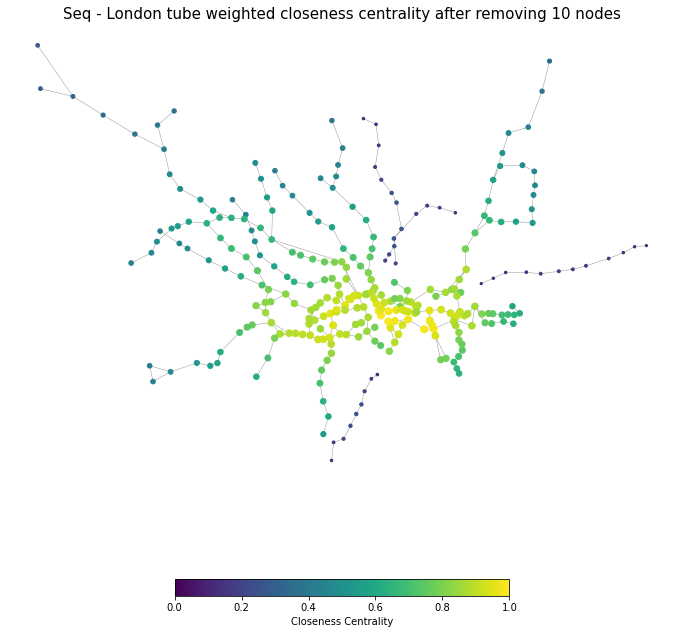

In [385]:
clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in g_shp_un.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in g_shp_un.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Seq - London tube weighted closeness centrality after removing 10 nodes",fontsize=15)
plt.show()

### 2.1.1 Impact Measure

In [386]:
print(nx.info(g_shp_un))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un)}')
print(f'Highest degree node: {sorted(g_shp_un.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 309
Average degree:   2.0878
Number of connected components:8
Highest degree node: ((-0.1571, 51.5226), 7)


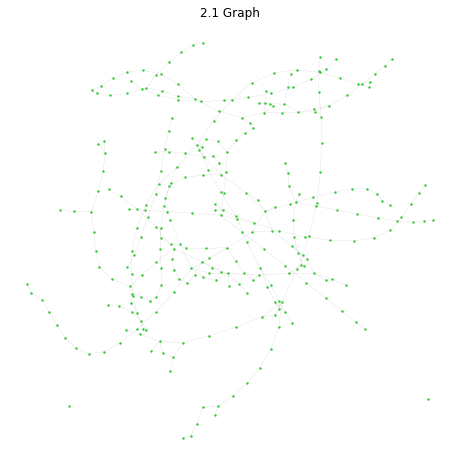

In [387]:
pos = nx.spring_layout(g_shp_un)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.1 Graph', fontsize=12)
plt.show()

In [388]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un), key=len, reverse=True)
Gsub = g_shp_un.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:44.59%
Name: 
Type: Graph
Number of nodes: 132
Number of edges: 145
Average degree:   2.1970
Number of connected components:1
Highest degree nodes: 
 	(-0.1571, 51.5226): 7
 	(-0.1973, 51.492): 6
 	(-0.2547, 51.4951): 5
 	(-0.1755, 51.5154): 5
 	(-0.1803, 51.5472): 4


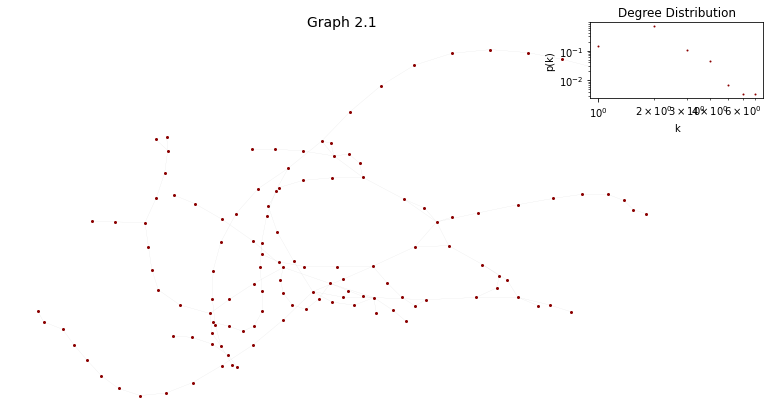

In [389]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Graph 2.1', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [390]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.2065, 51.4907), 1.0), ((-0.2678, 51.4946), 1.0), ((-0.4524, 51.4713), 1.0), ((-0.4476, 51.4598), 1.0), ((-0.1829, 51.4945), 0.3333333333333333)]
avg clustering coefficient: 0.04343434343434343


fast greedy

In [391]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 11


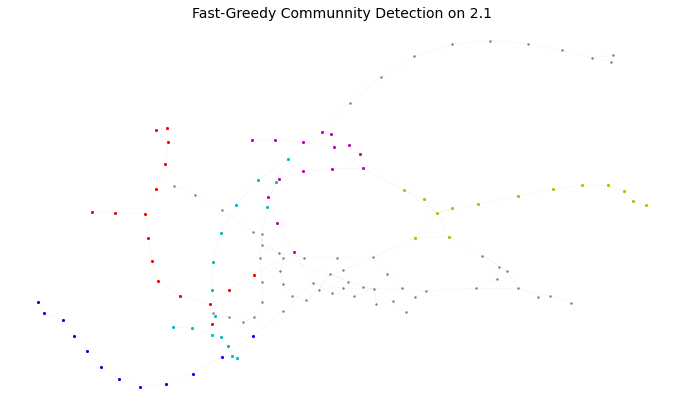

In [392]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.1', fontsize=14)

plt.show()

In [393]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [394]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 (-0.432, 51.6294)
	 (-0.3366, 51.5793)
	 (-0.561, 51.6679)
	 (-0.3533, 51.5795)
	 (-0.424, 51.6111)
community 1:
	 (-0.3714, 51.5753)
	 (-0.2882, 51.5101)
	 (-0.3366, 51.5569)
	 (-0.2887, 51.5175)
	 (-0.4499, 51.5538)
community 2:
	 (-0.2547, 51.4951)
	 (-0.2251, 51.4936)
	 (-0.2801, 51.5028)
	 (-0.2754, 51.4915)
	 (-0.188, 51.519)
community 3:
	 (-0.1973, 51.492)
	 (-0.1829, 51.4945)
	 (-0.2139, 51.4905)
	 (-0.1925, 51.5009)
	 (-0.1953, 51.4872)
community 4:
	 (-0.2478, 51.5326)
	 (-0.1854, 51.53)
	 (-0.1939, 51.5351)
	 (-0.2047, 51.5341)
	 (-0.3034, 51.5621)


louvian algorithm

In [395]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 10


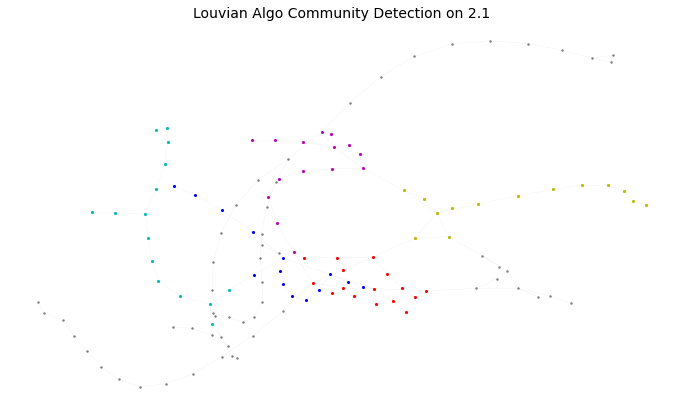

In [396]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Louvian Algo Community Detection on 2.1', fontsize=14)

plt.show()

In [397]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (-0.1571, 51.5226)
	 (-0.1755, 51.5154)
	 (-0.1967, 51.5094)
	 (-0.1494, 51.5142)
	 (-0.1631, 51.5225)
community 1:
	 (-0.432, 51.6294)
	 (-0.3366, 51.5793)
	 (-0.561, 51.6679)
	 (-0.3533, 51.5795)
	 (-0.424, 51.6111)
community 2:
	 (-0.2547, 51.4951)
	 (-0.2251, 51.4936)
	 (-0.2801, 51.5028)
	 (-0.2754, 51.4915)
	 (-0.188, 51.519)
community 3:
	 (-0.1973, 51.492)
	 (-0.1829, 51.4945)
	 (-0.2139, 51.4905)
	 (-0.1925, 51.5009)
	 (-0.1953, 51.4872)
community 4:
	 (-0.1803, 51.5472)
	 (-0.2795, 51.5635)
	 (-0.2215, 51.5492)
	 (-0.2786, 51.5846)
	 (-0.2503, 51.5542)


In [398]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.7934126040428061
modularity of louvain: 0.798834720570749


In [399]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9243580846634282
performance of louvain: 0.917881101087208


### 2.2 Betweenness Centrality (sequential)

In [400]:
# duplicate shapefile
g_shp1 = source

df = nx.to_pandas_edgelist(g_shp1)
list(g_shp1.edges(data = True))[0]
list(g_shp1.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp1.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp1.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp1,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp1, 'station')
g_shp_un1 = g_shp1.to_undirected()

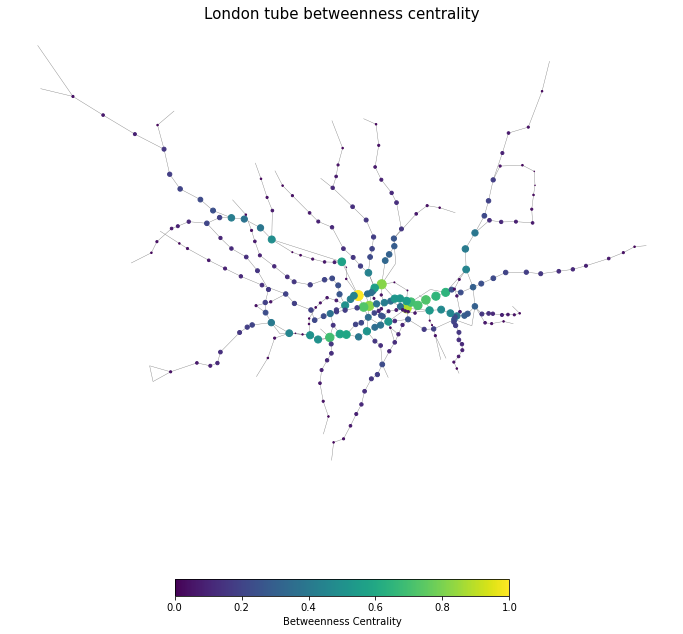

In [401]:
#Let us compute the betweenness centrality for the network, considering the distance between stations:
bet_london_w=nx.betweenness_centrality(g_shp_un1, weight='distance', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un1,bet_london_w,'betweenness_w')

betweenness_w_values=[(i[1]['betweenness_w']) for i in g_shp_un1.nodes(data=True)]

# Lets set colour and size of nodes according to betweenness values
bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in g_shp_un1.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values)*100) for i in g_shp_un1.nodes(data=True)]

# Plot graph
pos_shp = {xy: xy for xy in g_shp1.nodes()}
pos=pos_shp

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un1, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un1,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

In [402]:
maxbet_l = []
station_l = []
before_l = []
after_l = []

In [403]:
for a in range(0,10):
  #Let us compute the betweenness centrality for the network, considering the distance between stations:
  bet_london_w=nx.betweenness_centrality(g_shp_un1, weight='distance', normalized=False)
  # We can add these values to the nodes attributes:
  nx.set_node_attributes(g_shp_un1,bet_london_w,'betweenness_w')

  betweenness_w_values=[(i[1]['betweenness_w']) for i in g_shp_un1.nodes(data=True)]

  maxbet = [n for n in g_shp_un1.nodes() if g_shp_un1.nodes[n]['betweenness_w'] == max(betweenness_w_values)]
  remove_station = g_shp_un1.nodes[maxbet[0]]['station']
  
  # Existing nodes:
  l1=list(g_shp_un1.nodes)
  before = len(l1)
  #remove node with the
  g_shp_un1.remove_nodes_from(maxbet)

  # Nodes after the removal
  l2=list(g_shp_un1.nodes)
  after = len(l2)

  maxbet_l.append(maxbet)
  station_l.append(remove_station)
  before_l.append(before)
  after_l.append(after)

In [404]:
dict2 = {'Max Betwenness Coordinate': maxbet_l, 'Station to Remove': station_l, 'nodes before': before_l, 'nodes after': after_l} 
    
seq_bet = pd.DataFrame(dict2)
seq_bet

,Max Betwenness Coordinate,Station to Remove,nodes before,nodes after
0,"[(-0.1571, 51.5226)]",Baker Street,306,305
1,"[(-0.1973, 51.492)]",Earl's Court,305,304
2,"[(-0.1967, 51.5094)]",Notting Hill Gate,304,303
3,"[(-0.1238, 51.5308)]",King's Cross St. Pancras,303,302
4,"[(-0.0886, 51.5133)]",Bank,302,301
5,"[(-0.1223, 51.5074)]",Embankment,301,300
6,"[(-0.0502, 51.4982)]",Canada Water,300,299
7,"[(-0.2882, 51.5101)]",Ealing Common,299,298
8,"[(-0.0042, 51.5416)]",Stratford,298,297
9,"[(-0.1428, 51.5067)]",Green Park,297,296


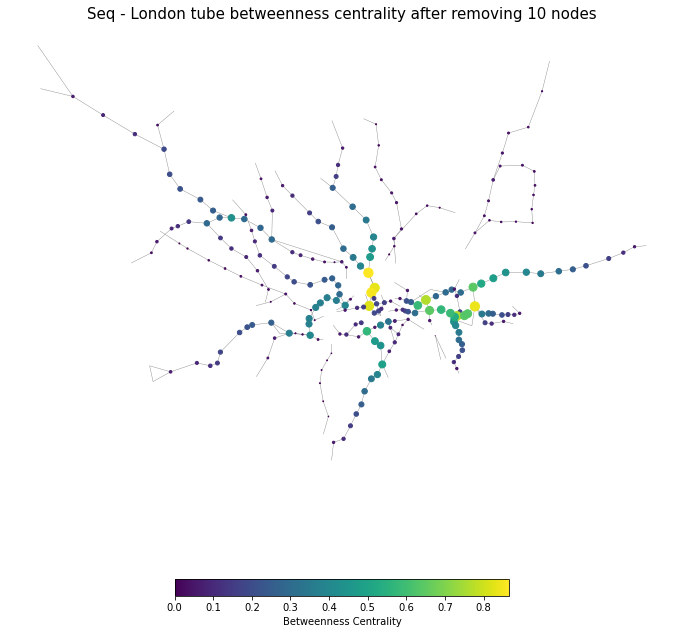

<Figure size 432x288 with 0 Axes>

In [405]:
# Lets set colour and size of nodes according to betweenness values
bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in g_shp_un1.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values)*100) for i in g_shp_un1.nodes(data=True)]


# Plot graph
pos_shp = {xy: xy for xy in g_shp1.nodes()}
pos=pos_shp

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un1, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un1,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Seq - London tube betweenness centrality after removing 10 nodes",fontsize=15)
plt.show()
plt.savefig('seq-bet')

### 2.2.1 Impact Measures

In [406]:
print(nx.info(g_shp_un1))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un1)}')
print(f'Highest degree node: {sorted(g_shp_un1.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 302
Average degree:   2.0405
Number of connected components:12
Highest degree node: ((0.0082, 51.5147), 5)


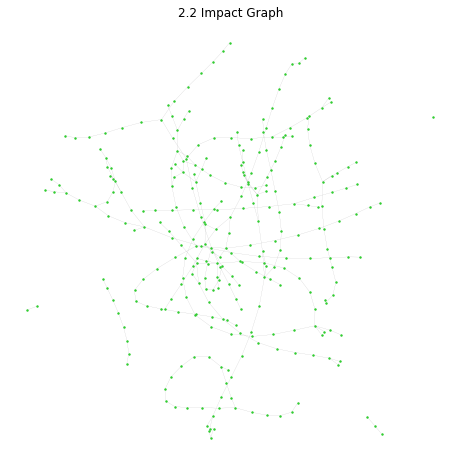

In [407]:
pos = nx.spring_layout(g_shp_un1)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un1,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un1, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.2 Impact Graph', fontsize=12)
plt.show()

In [408]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un1), key=len, reverse=True)
Gsub = g_shp_un1.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un1.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:24.66%
Name: 
Type: Graph
Number of nodes: 73
Number of edges: 77
Average degree:   2.1096
Number of connected components:1
Highest degree nodes: 
 	(0.0082, 51.5147): 5
 	(-0.0612, 51.5194): 4
 	(-0.056, 51.5117): 4
 	(-0.0173, 51.5077): 4
 	(-0.0823, 51.5178): 4


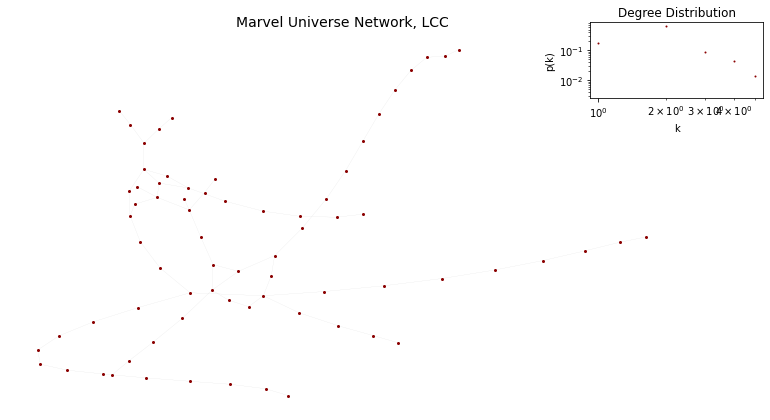

In [409]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un1) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un1.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [410]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.0265, 51.5097), 0.3333333333333333), ((-0.0203, 51.507), 0.3333333333333333), ((-0.0173, 51.5077), 0.16666666666666666), ((-0.0139, 51.5343), 0), ((-0.0149, 51.4781), 0)]
avg clustering coefficient: 0.01141552511415525


fast greedy

In [411]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 9


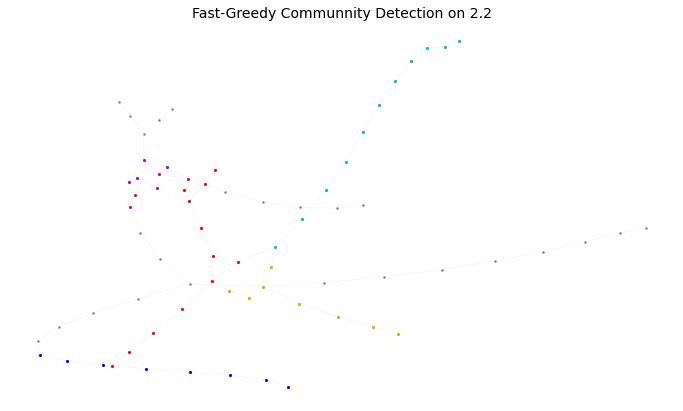

In [412]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.2', fontsize=14)

plt.show()

In [413]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [414]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 (-0.056, 51.5117)
	 (-0.0173, 51.5077)
	 (-0.0265, 51.5097)
	 (-0.0203, 51.507)
	 (-0.0396, 51.5123)
community 1:
	 (-0.0209, 51.5051)
	 (-0.0149, 51.4781)
	 (-0.0144, 51.4957)
	 (-0.0174, 51.4693)
	 (-0.0215, 51.5033)
community 2:
	 (-0.0612, 51.5194)
	 (-0.0823, 51.5178)
	 (-0.0332, 51.5249)
	 (-0.0726, 51.5154)
	 (-0.0766, 51.5098)
community 3:
	 (0.0082, 51.5147)
	 (-0.0066, 51.5079)
	 (0.0319, 51.5021)
	 (0.0226, 51.5027)
	 (0.0039, 51.5005)
community 4:
	 (0.1469, 51.5417)
	 (0.1655, 51.5443)
	 (0.2184, 51.5539)
	 (0.1014, 51.5385)
	 (0.1977, 51.5496)


louvian algorithm

In [415]:
# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 10


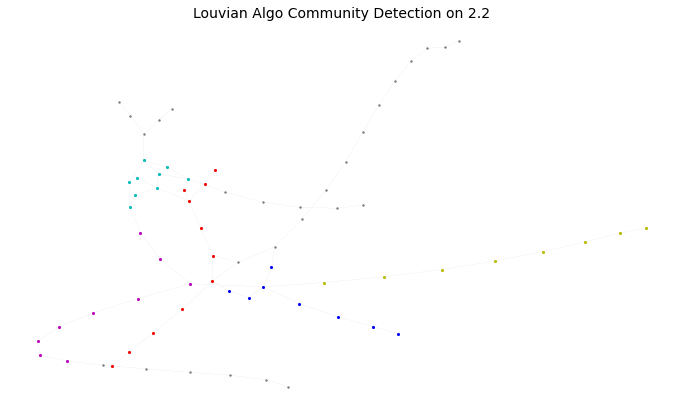

In [416]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Louvian Algo Community Detection on 2.2', fontsize=14)

plt.show()

In [417]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (-0.056, 51.5117)
	 (-0.0173, 51.5077)
	 (-0.0265, 51.5097)
	 (-0.0396, 51.5123)
	 (-0.013, 51.5107)
community 1:
	 (-0.0612, 51.5194)
	 (-0.0823, 51.5178)
	 (-0.0332, 51.5249)
	 (-0.0726, 51.5154)
	 (-0.0766, 51.5098)
community 2:
	 (0.0056, 51.5287)
	 (-0.0119, 51.5248)
	 (0.1014, 51.5385)
	 (0.0172, 51.5313)
	 (-0.0247, 51.5269)
community 3:
	 (0.0716, 51.5096)
	 (0.0465, 51.5084)
	 (0.0336, 51.5093)
	 (0.055, 51.5087)
	 (0.0276, 51.5095)
community 4:
	 (0.0082, 51.5147)
	 (-0.0066, 51.5079)
	 (0.0319, 51.5021)
	 (0.0226, 51.5027)
	 (0.0039, 51.5005)


impact masures

In [418]:
print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.7457412717152976
modularity of louvain: 0.7319109461966604


In [419]:
print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9143835616438356
performance of louvain: 0.9257990867579908


### 2.3 Degree Centrality (sequential)

In [420]:
# duplicate shapefile
g_shp4 = source

df = nx.to_pandas_edgelist(g_shp4)
list(g_shp4.edges(data = True))[0]
list(g_shp4.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp4.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp4.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp4,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp4, 'station')
g_shp_un4 = g_shp4.to_undirected()

In [421]:
#Let us compute the degree centrality
deg_dad=nx.degree(g_shp_un4)

# Print degree as list: 
list(deg_dad)[0:10]

[((-0.1571, 51.5226), 7),
 ((-0.1631, 51.5225), 2),
 ((-0.1466, 51.5234), 2),
 ((-0.1247, 51.508), 3),
 ((-0.1223, 51.5074), 4),
 ((-0.1342, 51.5098), 4),
 ((-0.1679, 51.5199), 2),
 ((-0.1755, 51.5154), 5),
 ((-0.1001, 51.4943), 3),
 ((-0.1115, 51.4991), 2)]

In [422]:
# Let us add the degree data as attribute to the nodes in the graph
# Data needs to be in the form of dictionary, in which nodes are the keys and attibutes are the values.
nx.set_node_attributes(g_shp_un4,dict(deg_dad),'degree')

# To check nodes attributes
list(g_shp_un4.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {'degree': 7, 'station': 'Baker Street'}),
 ((-0.1631, 51.5225), {'degree': 2, 'station': 'Marylebone'}),
 ((-0.1466, 51.5234), {'degree': 2, 'station': "Regent's Park"}),
 ((-0.1247, 51.508), {'degree': 3, 'station': 'Charing Cross'}),
 ((-0.1223, 51.5074), {'degree': 4, 'station': 'Embankment'}),
 ((-0.1342, 51.5098), {'degree': 4, 'station': 'Picadilly Circus'}),
 ((-0.1679, 51.5199), {'degree': 2, 'station': 'Edgware Road (B)'}),
 ((-0.1755, 51.5154), {'degree': 5, 'station': 'Paddington'}),
 ((-0.1001, 51.4943), {'degree': 3, 'station': 'Elephant & Castle'}),
 ((-0.1115, 51.4991), {'degree': 2, 'station': 'Lambeth North'})]

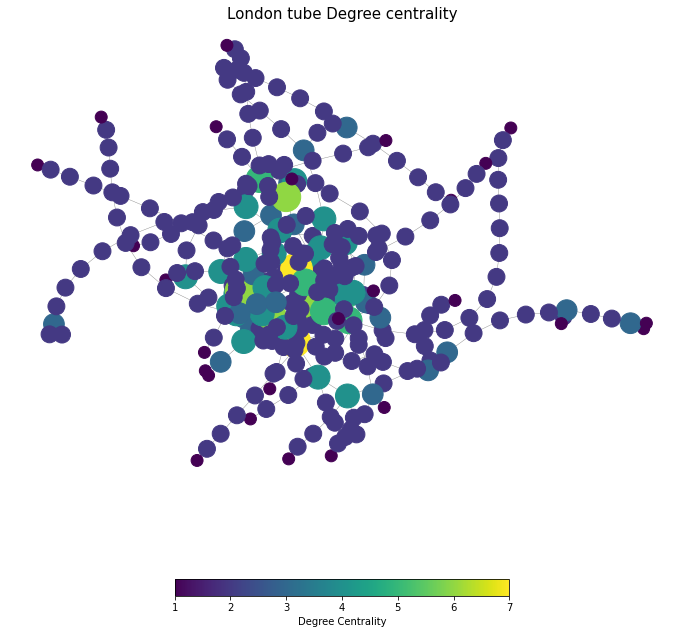

In [423]:
# Return degree attributes that we will use for the colour of nodes 
deg_color=[(node['degree']) for i, node in g_shp_un4.nodes(data=True)]
deg_size=[(float(node['degree'])/max(deg_color)*1000) for i, node in g_shp_un4.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

pos=nx.spring_layout(g_shp_un4)

# nx.draw_networkx_labels(g_shp_un4, pos,font_size=9,
#         font_color='black')
nx.draw_networkx_edges(g_shp_un4, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un4,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)


plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube Degree centrality",fontsize=15)
plt.show()

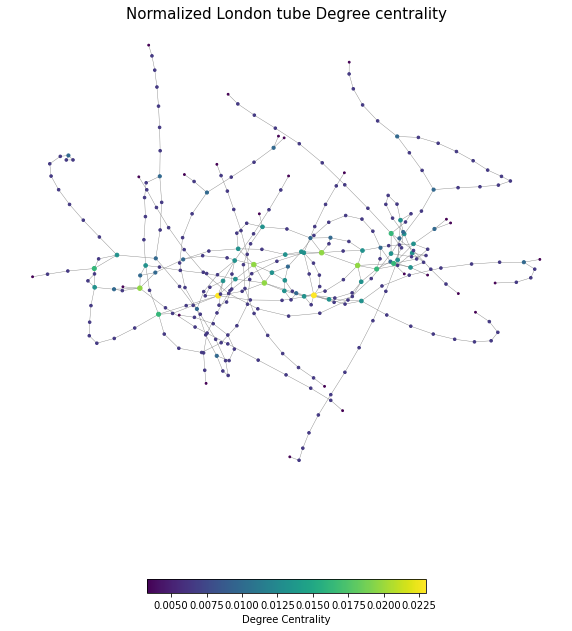

In [424]:
#  We can calculate the normalised version of degree centrality using networkx function:
deg_dad_norm =nx.degree_centrality(g_shp_un4)

nx.set_node_attributes(g_shp_un4,dict(deg_dad_norm),'degree_norm')

deg_color_norm=[(node['degree_norm']) for i, node in g_shp_un4.nodes(data=True)]
deg_size_norm=[(node['degree_norm']*1000) for i, node in g_shp_un4.nodes(data=True)]

fig, ax = plt.subplots(figsize=(10,12))

pos=nx.spring_layout(g_shp_un4)
nx.draw_networkx_edges(g_shp_un4, pos,edge_color='gray', 
        width=0.4)
# nx.draw_networkx_labels(g_shp_un4, pos,font_size=9,
#         font_color='black')
nod=nx.draw_networkx_nodes(g_shp_un4,
        pos = pos,
        node_color= deg_color_norm,
        node_size= deg_size_norm)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Normalized London tube Degree centrality",fontsize=15)
plt.show()

#Note that values now go from 0 to 1

In [425]:
maxdeg_l = []
station_l = []
before_l = []
after_l = []

In [426]:
for a in range(0,10):
  # degree centrality
  deg_dad_norm = nx.degree_centrality(g_shp_un4)
  # We can add these values to the nodes attributes:
  nx.set_node_attributes(g_shp_un4,dict(deg_dad_norm),'degree_n')
  degree_n_values=[(i[1]['degree_n']) for i in g_shp_un4.nodes(data=True)]

  maxdeg = []
  for n in g_shp_un4.nodes():
    if g_shp_un4.nodes[n]['degree_n'] == max(degree_n_values):
      maxdeg.append(n)
      break

  # maxdeg = [n for n in g_shp_un4.nodes() if g_shp_un4.nodes[n]['degree_n'] == max(degree_n_values)]
  print(maxdeg)
  remove_station = g_shp_un4.nodes[maxdeg[0]]['station']

  # Existing nodes:
  l1=list(g_shp_un4.nodes)
  before = len(l1)
  #remove node with the

  g_shp_un4.remove_nodes_from(maxdeg)
  
  # Nodes after the removal
  l2=list(g_shp_un4.nodes)
  after = len(l2)

  maxdeg_l.append(maxdeg)
  station_l.append(remove_station)
  before_l.append(before)
  after_l.append(after)

[(-0.1571, 51.5226)]
[(-0.1238, 51.5308)]
[(-0.1143, 51.5036)]
[(-0.1415, 51.515)]
[(-0.1973, 51.492)]
[(-0.1755, 51.5154)]
[(-0.0886, 51.5133)]
[(-0.2547, 51.4951)]
[(-0.1428, 51.5067)]
[(0.0082, 51.5147)]


In [430]:
dict5 = {'Max Degree Coordinate': maxdeg_l, 'Station to Remove': station_l, 'nodes before': before_l, 'nodes after': after_l} 
    
seq_clo = pd.DataFrame(dict5)
seq_clo

,Max Degree Coordinate,Station to Remove,nodes before,nodes after
0,"[(-0.1571, 51.5226)]",Baker Street,306,305
1,"[(-0.1238, 51.5308)]",King's Cross St. Pancras,305,304
2,"[(-0.1143, 51.5036)]",Waterloo,304,303
3,"[(-0.1415, 51.515)]",Oxford Circus,303,302
4,"[(-0.1973, 51.492)]",Earl's Court,302,301
5,"[(-0.1755, 51.5154)]",Paddington,301,300
6,"[(-0.0886, 51.5133)]",Bank,300,299
7,"[(-0.2547, 51.4951)]",Turnham Green,299,298
8,"[(-0.1428, 51.5067)]",Green Park,298,297
9,"[(0.0082, 51.5147)]",Canning Town,297,296


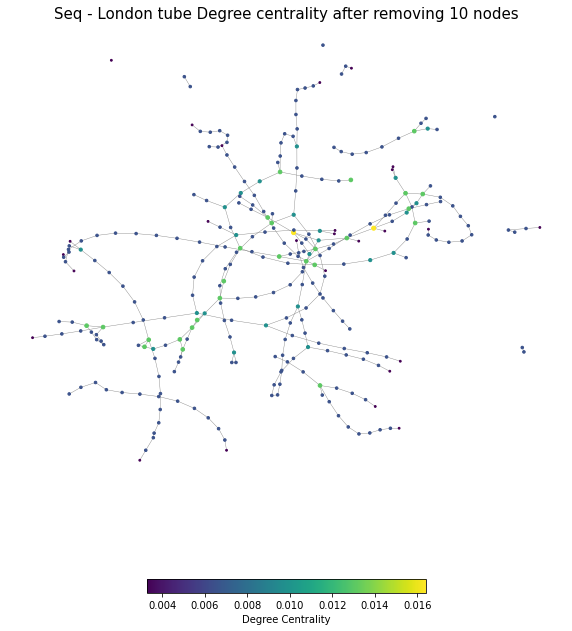

In [431]:
deg_color_norm=[(node['degree_norm']) for i, node in g_shp_un4.nodes(data=True)]
deg_size_norm=[(node['degree_norm']*1000) for i, node in g_shp_un4.nodes(data=True)]

fig, ax = plt.subplots(figsize=(10,12))

pos=nx.spring_layout(g_shp_un4)
nx.draw_networkx_edges(g_shp_un4, pos,edge_color='gray', 
        width=0.4)
# nx.draw_networkx_labels(g_shp_un4, pos,font_size=9,
#         font_color='black')
nod=nx.draw_networkx_nodes(g_shp_un4,
        pos = pos,
        node_color= deg_color_norm,
        node_size= deg_size_norm)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Seq - London tube Degree centrality after removing 10 nodes",fontsize=15)
plt.show()

### 2.3.1 Impact Measures

In [433]:
print(nx.info(g_shp_un4))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un4)}')
print(f'Highest degree node: {sorted(g_shp_un4.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 296
Average degree:   2.0000
Number of connected components:13
Highest degree node: ((-0.0173, 51.5077), 4)


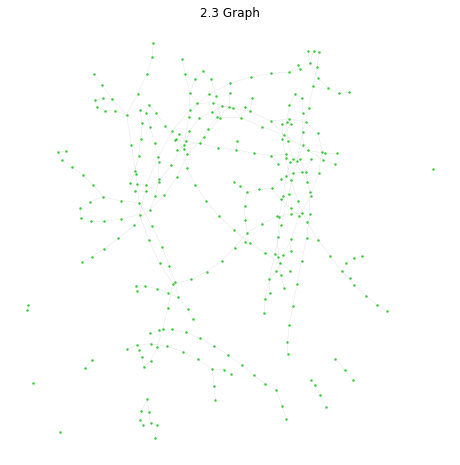

In [434]:
pos = nx.spring_layout(g_shp_un4)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un4,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un4, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.3 Graph', fontsize=12)
plt.show()

In [435]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un4), key=len, reverse=True)
Gsub = g_shp_un4.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un4.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:76.01%
Name: 
Type: Graph
Number of nodes: 225
Number of edges: 237
Average degree:   2.1067
Number of connected components:1
Highest degree nodes: 
 	(-0.0823, 51.5178): 4
 	(-0.0332, 51.5249): 4
 	(-0.12, 51.5174): 4
 	(-0.1967, 51.5094): 4
 	(-0.0042, 51.5416): 4


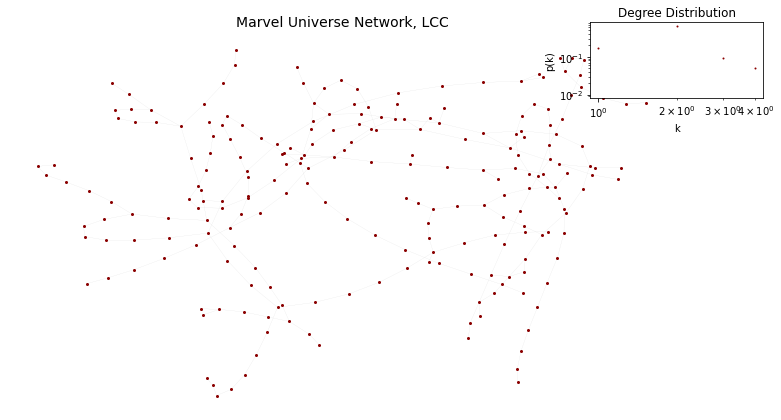

In [436]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un4) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un4.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [438]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.1342, 51.5098), 1.0), ((-0.1387, 51.5342), 1.0), ((-0.4524, 51.4713), 1.0), ((-0.4476, 51.4598), 1.0), ((-0.1247, 51.508), 0.3333333333333333)]
avg clustering coefficient: 0.027407407407407405


fast greedy

In [439]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 16


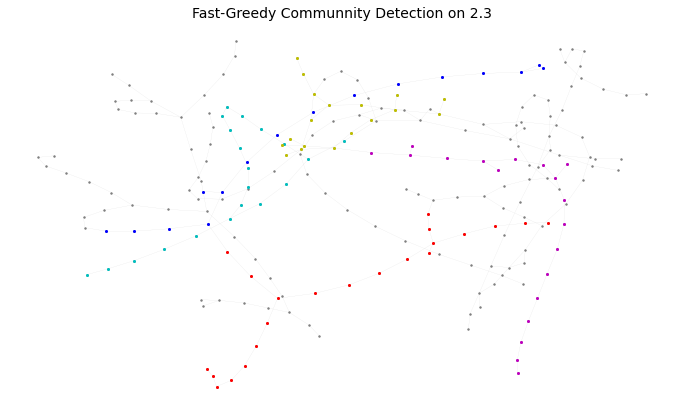

In [440]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.3', fontsize=14)

plt.show()

In [441]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [442]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (-0.1967, 51.5094)
	 (-0.2597, 51.5237)
	 (-0.1586, 51.5136)
	 (-0.3017, 51.5152)
	 (-0.2809, 51.518)
community 1:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 2:
	 (-0.123, 51.4723)
	 (-0.1001, 51.4943)
	 (-0.0864, 51.5052)
	 (-0.0637, 51.4979)
	 (-0.1525, 51.4431)
community 3:
	 (-0.0612, 51.5194)
	 (-0.0502, 51.4982)
	 (-0.056, 51.5117)
	 (-0.0209, 51.5051)
	 (-0.0173, 51.5077)
community 4:
	 (-0.2801, 51.5028)
	 (-0.2882, 51.5101)
	 (-0.4227, 51.4669)
	 (-0.3072, 51.5011)
	 (-0.2997, 51.5407)


louvian algorithm

In [443]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 17


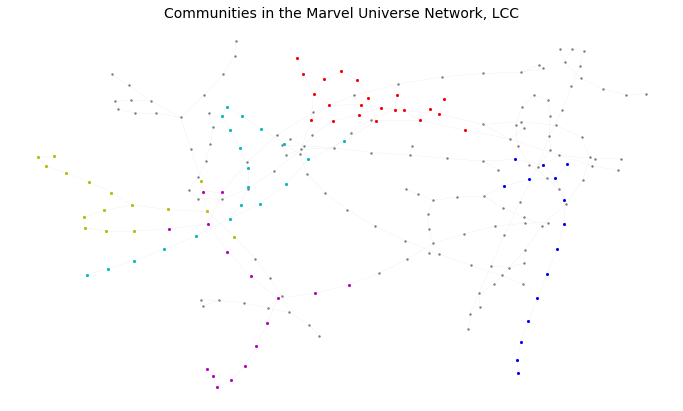

In [444]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Communities in the Marvel Universe Network, LCC', fontsize=14)

plt.show()

In [445]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (-0.0332, 51.5249)
	 (-0.0042, 51.5416)
	 (-0.0612, 51.5194)
	 (-0.056, 51.5117)
	 (-0.0173, 51.5077)
community 1:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 2:
	 (-0.2597, 51.5237)
	 (-0.2801, 51.5028)
	 (-0.2882, 51.5101)
	 (-0.3017, 51.5152)
	 (-0.2809, 51.518)
community 3:
	 (-0.3714, 51.5753)
	 (-0.3366, 51.5793)
	 (-0.397, 51.5765)
	 (-0.4125, 51.5732)
	 (-0.3184, 51.5784)
community 4:
	 (-0.123, 51.4723)
	 (-0.1525, 51.4431)
	 (-0.148, 51.4527)
	 (-0.1598, 51.4361)
	 (-0.1384, 51.4618)


In [446]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.856789332193915
modularity of louvain: 0.855480781213837


In [447]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9448412698412698
performance of louvain: 0.9492063492063492


### 2.4 Closeness Centrality (non-sequential)

In [448]:
g_shp2 = source
df = nx.to_pandas_edgelist(g_shp2)
list(g_shp2.edges(data = True))[0]
list(g_shp2.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp2.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp2.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp2,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp2, 'station')
g_shp_un2 = g_shp2.to_undirected()

In [449]:
#Weighted closeness centrality: 
clos_w=nx.closeness_centrality(g_shp_un2, distance='distance')
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un2,clos_w,'closeness_w')
df = pd.DataFrame.from_dict(clos_w,columns=['closeness_w'],orient='index')

In [450]:
df.sort_values(by='closeness_w', ascending=False)[0:10]

,closeness_w
"(-0.1415, 51.515)",0.000089
"(-0.131, 51.5165)",0.000089
"(-0.1342, 51.5098)",0.000088
"(-0.12, 51.5174)",0.000088
"(-0.1281, 51.5113)",0.000088
"(-0.1494, 51.5142)",0.000088
"(-0.1428, 51.5067)",0.000088
"(-0.1247, 51.508)",0.000088
"(-0.1223, 51.5074)",0.000088
"(-0.1243, 51.5129)",0.000087


In [451]:
maxclo_l =[]
station_l =[]

In [452]:
#If we want to remove the node with the top 10 value of closeness centrality:
for k in range(0,10):
  clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un2.nodes(data=True)]
  maxclo = [n for n in g_shp_un2.nodes() if g_shp_un2.nodes[n]['closeness_w'] == max(clos_w_val)]
  # print(maxclo)
  remove_station = g_shp_un2.nodes[maxclo[0]]['station']
  g_shp_un2.remove_nodes_from(maxclo)
  maxclo_l.append(maxclo)
  station_l.append(remove_station)

In [453]:
dict3 = {'Max Closeness Coordinate': maxclo_l, 'Station to Remove': station_l}
    
nonseq_clos = pd.DataFrame(dict3)
nonseq_clos

,Max Closeness Coordinate,Station to Remove
0,"[(-0.1415, 51.515)]",Oxford Circus
1,"[(-0.131, 51.5165)]",Tottenham Court Road
2,"[(-0.1342, 51.5098)]",Picadilly Circus
3,"[(-0.12, 51.5174)]",Holborn
4,"[(-0.1281, 51.5113)]",Leicester Square
5,"[(-0.1494, 51.5142)]",Bond Street
6,"[(-0.1428, 51.5067)]",Green Park
7,"[(-0.1247, 51.508)]",Charing Cross
8,"[(-0.1223, 51.5074)]",Embankment
9,"[(-0.1243, 51.5129)]",Covent Garden


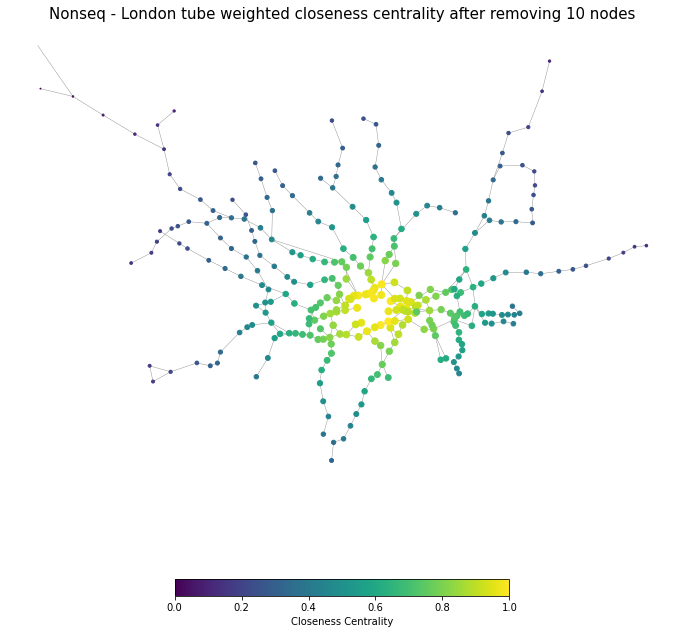

In [454]:
clos_w_val=[(i[1]['closeness_w']) for i in g_shp_un2.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in g_shp_un2.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in g_shp_un2.nodes(data=True)]

pos_shp = {xy: xy for xy in g_shp2.nodes()}
pos=pos_shp

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un2, pos,edge_color='gray',width=0.4)

nod=nx.draw_networkx_nodes(g_shp_un2,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Nonseq - London tube weighted closeness centrality after removing 10 nodes",fontsize=15)
plt.show()

### 2.4.1 Impact Measures

In [455]:
print(nx.info(g_shp_un2))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un2)}')
print(f'Highest degree node: {sorted(g_shp_un2.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 326
Average degree:   2.2027
Number of connected components:1
Highest degree node: ((-0.1238, 51.5308), 7)


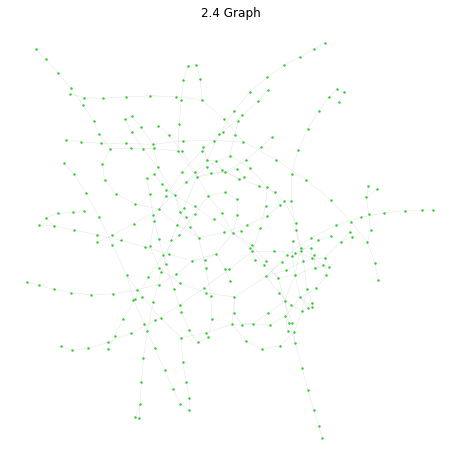

In [456]:
pos = nx.spring_layout(g_shp_un2)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un2,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un2, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.4 Graph', fontsize=12)
plt.show()

In [457]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un2), key=len, reverse=True)
Gsub = g_shp_un2.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un2.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:100.00%
Name: 
Type: Graph
Number of nodes: 296
Number of edges: 326
Average degree:   2.2027
Number of connected components:1
Highest degree nodes: 
 	(-0.1238, 51.5308): 7
 	(-0.1571, 51.5226): 6
 	(-0.0886, 51.5133): 6
 	(-0.1973, 51.492): 6
 	(-0.1755, 51.5154): 5


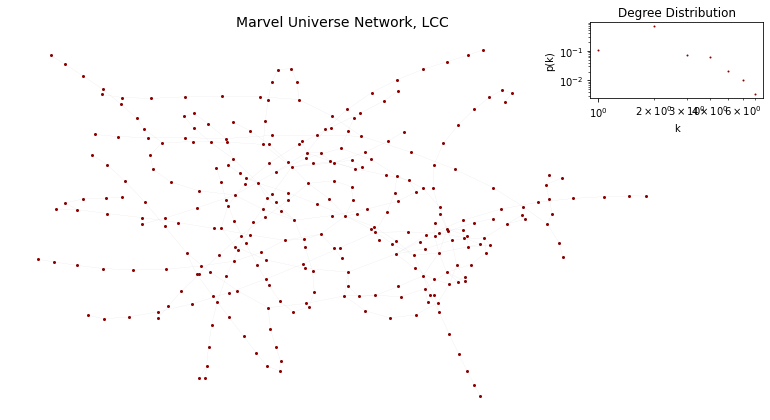

In [458]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un2) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un2.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [459]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.2065, 51.4907), 1.0), ((-0.2678, 51.4946), 1.0), ((-0.1387, 51.5342), 1.0), ((-0.4524, 51.4713), 1.0), ((-0.4476, 51.4598), 1.0)]
avg clustering coefficient: 0.027815315315315312


fast greedy

In [460]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 18


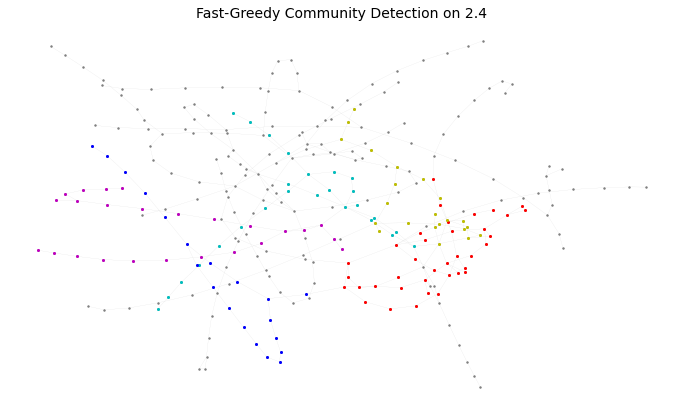

In [461]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Community Detection on 2.4', fontsize=14)

plt.show()

In [462]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [463]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 (-0.056, 51.5117)
	 (0.0082, 51.5147)
	 (-0.0332, 51.5249)
	 (-0.0042, 51.5416)
	 (-0.0612, 51.5194)
community 1:
	 (-0.1238, 51.5308)
	 (-0.0886, 51.5186)
	 (-0.1065, 51.5642)
	 (-0.1439, 51.5238)
	 (-0.0979, 51.5204)
community 2:
	 (-0.1426, 51.5392)
	 (-0.1337, 51.5282)
	 (-0.1932, 51.6012)
	 (-0.1353, 51.5653)
	 (-0.1458, 51.5777)
community 3:
	 (-0.0886, 51.5133)
	 (-0.1143, 51.5036)
	 (-0.0864, 51.5052)
	 (-0.123, 51.4723)
	 (-0.1001, 51.4943)
community 4:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)


louvian algorithm

In [464]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 18


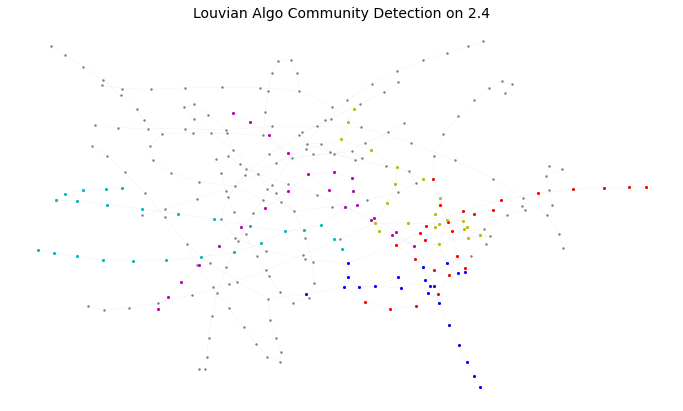

In [465]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Louvian Algo Community Detection on 2.4', fontsize=14)

plt.show()

In [466]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (0.0082, 51.5147)
	 (-0.0209, 51.5051)
	 (-0.0173, 51.5077)
	 (-0.0203, 51.507)
	 (-0.0265, 51.5097)
community 1:
	 (-0.1426, 51.5392)
	 (-0.1337, 51.5282)
	 (-0.1932, 51.6012)
	 (-0.1353, 51.5653)
	 (-0.1458, 51.5777)
community 2:
	 (-0.1238, 51.5308)
	 (-0.0886, 51.5186)
	 (-0.1065, 51.5642)
	 (-0.0979, 51.5204)
	 (-0.1053, 51.5203)
community 3:
	 (-0.0886, 51.5133)
	 (-0.1143, 51.5036)
	 (-0.0864, 51.5052)
	 (-0.123, 51.4723)
	 (-0.1001, 51.4943)
community 4:
	 (-0.0823, 51.5178)
	 (-0.056, 51.5117)
	 (-0.0332, 51.5249)
	 (-0.0042, 51.5416)
	 (-0.0612, 51.5194)


In [467]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.8521350069630019
modularity of louvain: 0.8519421129888216


In [468]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9424415941365094
performance of louvain: 0.9467475950526798


### 2.5 Betweenness Centrality (non-sequential)

In [469]:
g_shp3 = source
df = nx.to_pandas_edgelist(g_shp3)
list(g_shp3.edges(data = True))[0]
list(g_shp3.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp3.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp3.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp3,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp3, 'station')
g_shp_un3 = g_shp3.to_undirected()

In [470]:
#Let us compute the betweenness centrality for the network, considering the distance between stations:
bet_london_w=nx.betweenness_centrality(g_shp_un3, weight='distance', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un3,bet_london_w,'betweenness_w')
df1 = pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')

In [471]:
df1.sort_values(by='betweenness_w', ascending=False)[0:10]

,betweenness_w
"(-0.1571, 51.5226)",13194.0
"(-0.0886, 51.5133)",11605.0
"(-0.1415, 51.515)",10847.0
"(-0.1238, 51.5308)",10794.0
"(-0.1494, 51.5142)",9597.0
"(-0.0612, 51.5194)",9500.0
"(-0.0726, 51.5154)",9334.0
"(-0.1973, 51.492)",9201.0
"(-0.0823, 51.5178)",9195.0
"(-0.047, 51.5221)",8652.0


In [472]:
maxbet_l = []
station_l =[]

In [473]:
#If we want to remove the node with the top 10 value of closeness centrality:
for k in range(0,10):
  betweenness_w_values=[(i[1]['betweenness_w']) for i in g_shp_un3.nodes(data=True)]
  maxbet = [n for n in g_shp_un3.nodes() if g_shp_un3.nodes[n]['betweenness_w'] == max(betweenness_w_values)]
  # print(maxclo)
  remove_station = g_shp_un3.nodes[maxbet[0]]['station']
  g_shp_un3.remove_nodes_from(maxbet)
  maxbet_l.append(maxbet)
  station_l.append(remove_station)

In [474]:
dict4 = {'Max Betweenness Coordinate': maxbet_l, 'Station to Remove': station_l}
    
nonseq_bet = pd.DataFrame(dict4)
nonseq_bet

,Max Betweenness Coordinate,Station to Remove
0,"[(-0.1571, 51.5226)]",Baker Street
1,"[(-0.0886, 51.5133)]",Bank
2,"[(-0.1415, 51.515)]",Oxford Circus
3,"[(-0.1238, 51.5308)]",King's Cross St. Pancras
4,"[(-0.1494, 51.5142)]",Bond Street
5,"[(-0.0612, 51.5194)]",Whitechapel
6,"[(-0.0726, 51.5154)]",Aldgate East
7,"[(-0.1973, 51.492)]",Earl's Court
8,"[(-0.0823, 51.5178)]",Liverpool Street
9,"[(-0.047, 51.5221)]",Stepney Green


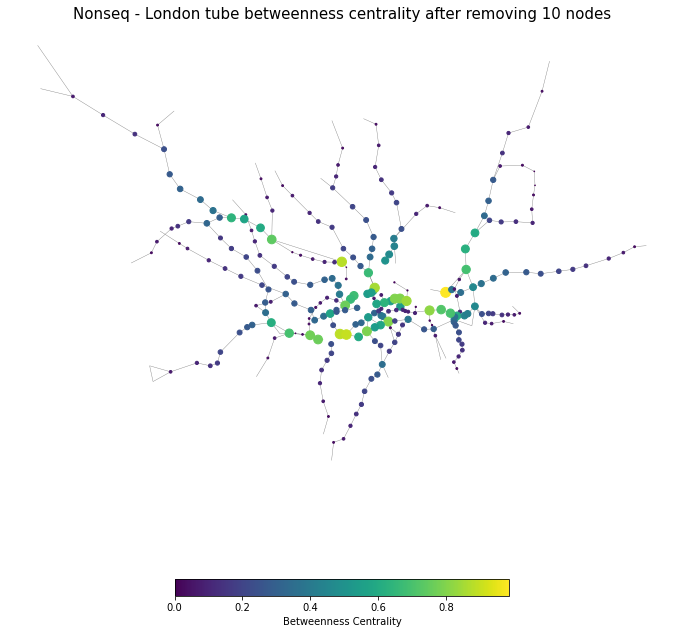

In [475]:
# Lets set colour and size of nodes according to betweenness values
bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in g_shp_un3.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values)*100) for i in g_shp_un3.nodes(data=True)]

# Plot graph
pos_shp = {xy: xy for xy in g_shp3.nodes()}
pos=pos_shp

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(g_shp_un3, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un3,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Nonseq - London tube betweenness centrality after removing 10 nodes",fontsize=15)
plt.show()
# plt.savefig('seq-bet')

### 2.5.1 Impact Measures

In [476]:
print(nx.info(g_shp_un3))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un3)}')
print(f'Highest degree node: {sorted(g_shp_un3.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 309
Average degree:   2.0878
Number of connected components:8
Highest degree node: ((0.0082, 51.5147), 5)


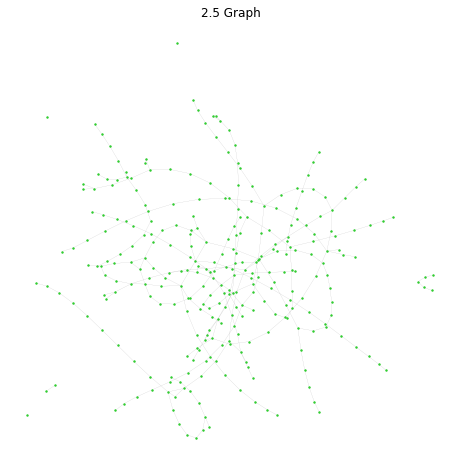

In [477]:
pos = nx.spring_layout(g_shp_un3)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un3,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un3, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.5 Graph', fontsize=12)
plt.show()

In [478]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un3), key=len, reverse=True)
Gsub = g_shp_un3.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un3.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:88.18%
Name: 
Type: Graph
Number of nodes: 261
Number of edges: 281
Average degree:   2.1533
Number of connected components:1
Highest degree nodes: 
 	(-0.1755, 51.5154): 5
 	(-0.1143, 51.5036): 5
 	(-0.2547, 51.4951): 5
 	(0.0082, 51.5147): 5
 	(-0.1223, 51.5074): 4


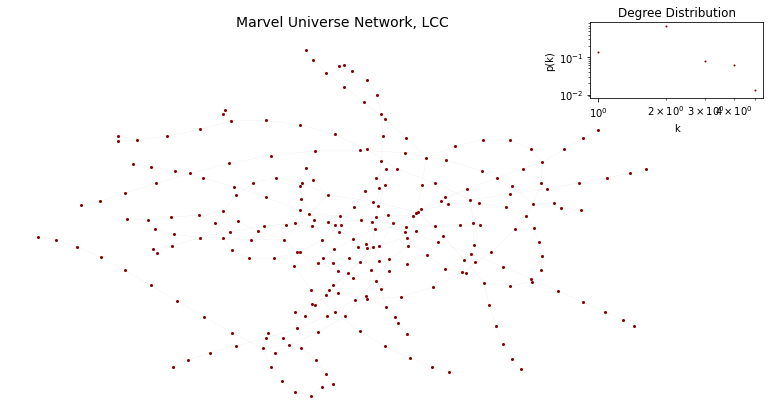

In [479]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un3) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un3.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [480]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.2678, 51.4946), 1.0), ((-0.1387, 51.5342), 1.0), ((-0.4524, 51.4713), 1.0), ((-0.4476, 51.4598), 1.0), ((-0.1247, 51.508), 0.3333333333333333)]
avg clustering coefficient: 0.02758620689655172


fast greedy

In [481]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 17


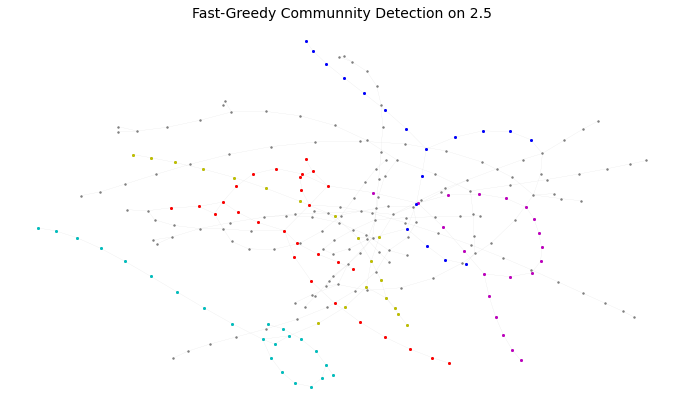

In [482]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.5', fontsize=14)

plt.show()

In [483]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [484]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 (0.0082, 51.5147)
	 (-0.0042, 51.5416)
	 (0.0056, 51.5287)
	 (-0.0173, 51.5077)
	 (-0.0332, 51.5249)
community 1:
	 (-0.1426, 51.5392)
	 (-0.1337, 51.5282)
	 (-0.1932, 51.6012)
	 (-0.1353, 51.5653)
	 (-0.1458, 51.5777)
community 2:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 3:
	 (-0.1223, 51.5074)
	 (-0.12, 51.5174)
	 (-0.1281, 51.5113)
	 (-0.1247, 51.508)
	 (-0.1342, 51.5098)
community 4:
	 (-0.2597, 51.5237)
	 (-0.2882, 51.5101)
	 (-0.3017, 51.5152)
	 (-0.2809, 51.518)
	 (-0.2474, 51.5168)


louvian algorithm

In [485]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 18


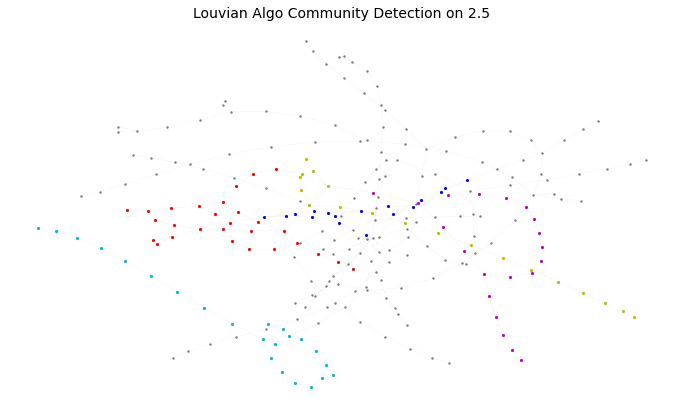

In [486]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Louvian Algo Community Detection on 2.5', fontsize=14)

plt.show()

In [487]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (0.0082, 51.5147)
	 (-0.0502, 51.4982)
	 (-0.0209, 51.5051)
	 (-0.0173, 51.5077)
	 (-0.0478, 51.4933)
community 1:
	 (-0.1426, 51.5392)
	 (-0.1337, 51.5282)
	 (-0.1932, 51.6012)
	 (-0.1353, 51.5653)
	 (-0.1458, 51.5777)
community 2:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 3:
	 (-0.0042, 51.5416)
	 (0.0056, 51.5287)
	 (-0.0332, 51.5249)
	 (0.081, 51.5396)
	 (0.0518, 51.5394)
community 4:
	 (-0.1143, 51.5036)
	 (-0.1223, 51.5074)
	 (-0.1254, 51.501)
	 (-0.1447, 51.4965)
	 (-0.1428, 51.5067)


In [488]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.8556755866820326
modularity of louvain: 0.859392611542407


In [489]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9455349248452697
performance of louvain: 0.9471559092248747


### 2.6 Degree Centrality(non-sequential)


In [523]:
g_shp5 = source
df = nx.to_pandas_edgelist(g_shp5)

list(g_shp5.edges(data = True))[0]
list(g_shp5.nodes(data=True))[0:10]
#Let's give to the nodes the names of the stations:

nod_st1={(e1):weight for e1, e2, weight in g_shp5.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp5.edges(data='station_2_')}

nod_all = {**nod_st1, **nod_st2}
nx.set_node_attributes(g_shp5,nod_all,'station')

node_labels = nx.get_node_attributes(g_shp5, 'station')
g_shp_un5 = g_shp5.to_undirected()


In [524]:
#Weighted degree centrality: 
deg_dad=nx.degree_centrality(g_shp_un5)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_shp_un5,deg_dad,'degree_w')
df = pd.DataFrame.from_dict(deg_dad,columns=['degree_w'],orient='index')


In [525]:
df.sort_values(by='degree_w', ascending=False)[0:10]

,degree_w
"(-0.1571, 51.5226)",0.022951
"(-0.1238, 51.5308)",0.022951
"(-0.1143, 51.5036)",0.019672
"(-0.1973, 51.492)",0.019672
"(-0.0886, 51.5133)",0.019672
"(-0.1428, 51.5067)",0.019672
"(-0.1415, 51.515)",0.019672
"(-0.1755, 51.5154)",0.016393
"(-0.2547, 51.4951)",0.016393
"(-0.056, 51.5117)",0.016393


In [526]:
maxdeg_l =[]
station_l =[]

In [528]:
#If we want to remove the node with the top 10 value of degree centrality:
for k in range(0,10):
  degree_n_values = [(i[1]['degree_w']) for i in g_shp_un5.nodes(data=True)]
  maxdeg = []

  for n in g_shp_un5.nodes():
    if g_shp_un5.nodes[n]['degree_w'] == max(degree_n_values):
      maxdeg.append(n)
      break
  
  remove_station = g_shp_un5.nodes[maxdeg[0]]['station']
  g_shp_un5.remove_nodes_from(maxdeg)
  maxdeg_l.append(maxdeg)
  station_l.append(remove_station)

[0.022950819672131147, 0.006557377049180328, 0.006557377049180328, 0.009836065573770491, 0.013114754098360656, 0.013114754098360656, 0.006557377049180328, 0.01639344262295082, 0.009836065573770491, 0.006557377049180328, 0.019672131147540982, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.003278688524590164, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.019672131147540982, 0.019672131147540982, 0.01639344262295082, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.013114754098360656, 0.013114754098360656, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.009836065573770491, 0.006557377049180328, 0.013114754098360656, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377049180328, 0.006557377

In [530]:
dict6 = {'Max Degree Coordinate': maxdeg_l, 'Station to Remove': station_l}
    
nonseq_deg = pd.DataFrame(dict6)
nonseq_deg

,Max Degree Coordinate,Station to Remove
0,"[(-0.1571, 51.5226)]",Baker Street
1,"[(-0.1238, 51.5308)]",King's Cross St. Pancras
2,"[(-0.1143, 51.5036)]",Waterloo
3,"[(-0.1415, 51.515)]",Oxford Circus
4,"[(-0.0886, 51.5133)]",Bank
5,"[(-0.1973, 51.492)]",Earl's Court
6,"[(-0.1428, 51.5067)]",Green Park
7,"[(-0.1755, 51.5154)]",Paddington
8,"[(-0.0823, 51.5178)]",Liverpool Street
9,"[(-0.2547, 51.4951)]",Turnham Green


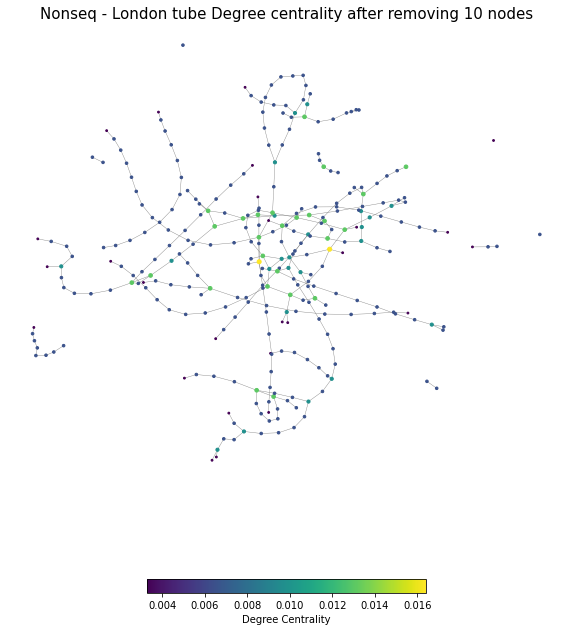

In [532]:

deg_color_norm=[(node['degree_w']) for i, node in g_shp_un5.nodes(data=True)]
deg_size_norm=[(node['degree_w']*1000) for i, node in g_shp_un5.nodes(data=True)]

fig, ax = plt.subplots(figsize=(10,12))

pos=nx.spring_layout(g_shp_un5)
nx.draw_networkx_edges(g_shp_un5, pos,edge_color='gray', 
        width=0.4)
# nx.draw_networkx_labels(g_shp_un4, pos,font_size=9,
#         font_color='black')
nod=nx.draw_networkx_nodes(g_shp_un5,
        pos = pos,
        node_color= deg_color_norm,
        node_size= deg_size_norm)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Nonseq - London tube Degree centrality after removing 10 nodes",fontsize=15)
plt.show()

### 2.6.1 Impact Measures

In [534]:
print(nx.info(g_shp_un5))
print(f'Number of connected components:{nx.number_connected_components(g_shp_un5)}')
print(f'Highest degree node: {sorted(g_shp_un5.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 296
Number of edges: 297
Average degree:   2.0068
Number of connected components:12
Highest degree node: ((0.0082, 51.5147), 5)


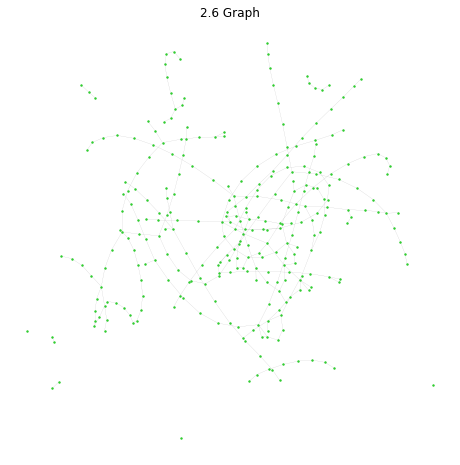

In [535]:
pos = nx.spring_layout(g_shp_un5)
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(g_shp_un5,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(g_shp_un5, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('2.6 Graph', fontsize=12)
plt.show()

In [536]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(g_shp_un5), key=len, reverse=True)
Gsub = g_shp_un5.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(g_shp_un5.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:78.38%
Name: 
Type: Graph
Number of nodes: 232
Number of edges: 244
Average degree:   2.1034
Number of connected components:1
Highest degree nodes: 
 	(0.0082, 51.5147): 5
 	(-0.0332, 51.5249): 4
 	(-0.12, 51.5174): 4
 	(-0.1967, 51.5094): 4
 	(-0.0042, 51.5416): 4


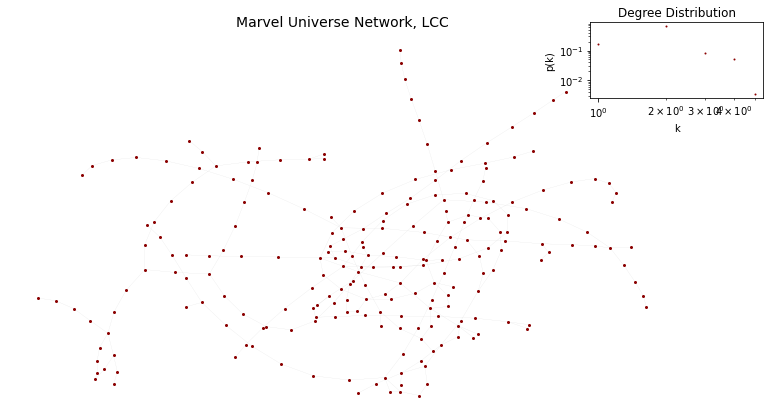

In [537]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(g_shp_un5) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/g_shp_un5.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

In [538]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[((-0.1342, 51.5098), 1.0), ((-0.1387, 51.5342), 1.0), ((-0.4524, 51.4713), 1.0), ((-0.4476, 51.4598), 1.0), ((-0.1247, 51.508), 0.3333333333333333)]
avg clustering coefficient: 0.02658045977011494


fast greedy

In [539]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 17


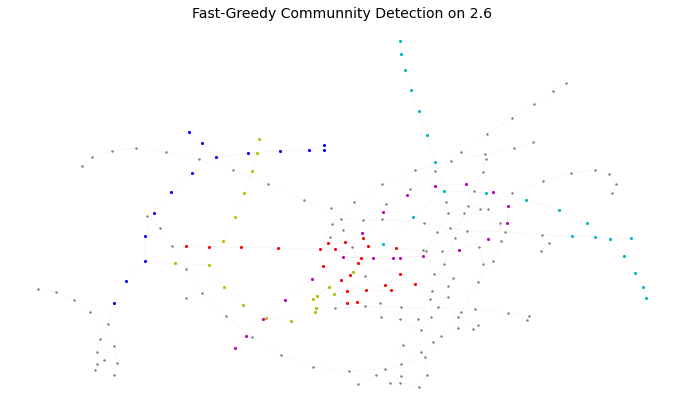

In [540]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Communnity Detection on 2.6', fontsize=14)

plt.show()

In [542]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [543]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 (0.0082, 51.5147)
	 (-0.0332, 51.5249)
	 (-0.0042, 51.5416)
	 (0.0056, 51.5287)
	 (-0.0209, 51.5051)
community 1:
	 (-0.1967, 51.5094)
	 (-0.2597, 51.5237)
	 (-0.1586, 51.5136)
	 (-0.3017, 51.5152)
	 (-0.2809, 51.518)
community 2:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 3:
	 (-0.2801, 51.5028)
	 (-0.2882, 51.5101)
	 (-0.3714, 51.5753)
	 (-0.397, 51.5765)
	 (-0.4125, 51.5732)
community 4:
	 (-0.561, 51.6679)
	 (-0.432, 51.6294)
	 (-0.3366, 51.5793)
	 (-0.5183, 51.6543)
	 (-0.4733, 51.6404)


louvian algorithm

In [544]:
from cdlib import algorithms

# let's try a different algorithm using cdlib
partitions = algorithms.louvain(Gsub)
communities_louvain = partitions.communities
print(f'number of communities: {len(communities_louvain)}')

number of communities: 15


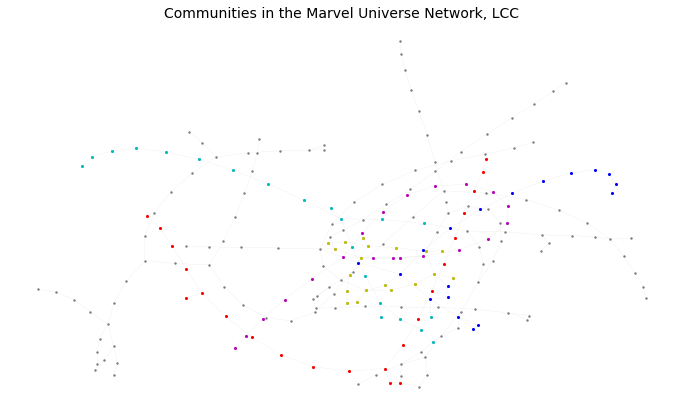

In [545]:

communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

fig, ax = plt.subplots(figsize=(12,7))

nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_louvain[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Communities in the Marvel Universe Network, LCC', fontsize=14)

plt.show()

In [546]:
for i, community in enumerate(communities_louvain[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')

community 0:
	 (-0.1426, 51.5392)
	 (-0.1337, 51.5282)
	 (-0.1932, 51.6012)
	 (-0.1353, 51.5653)
	 (-0.1458, 51.5777)
community 1:
	 (-0.123, 51.4723)
	 (-0.1001, 51.4943)
	 (-0.0864, 51.5052)
	 (-0.0637, 51.4979)
	 (-0.1525, 51.4431)
community 2:
	 (0.0341, 51.607)
	 (0.0083, 51.5683)
	 (0.0887, 51.5856)
	 (0.0912, 51.596)
	 (0.0899, 51.5756)
community 3:
	 (-0.0332, 51.5249)
	 (-0.0042, 51.5416)
	 (-0.0612, 51.5194)
	 (0.0056, 51.5287)
	 (-0.056, 51.5117)
community 4:
	 (-0.0502, 51.4982)
	 (-0.0209, 51.5051)
	 (-0.0478, 51.4933)
	 (-0.0525, 51.501)
	 (-0.0558, 51.5043)


In [547]:
from networkx.algorithms.community.quality import modularity

print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

modularity of fast-greedy: 0.8533912254770222
modularity of louvain: 0.8547097554420853


In [548]:
from networkx.algorithms.community.quality import performance

print(f'performance of fast-greedy: {performance(Gsub, communities_fg)}')
print(f'performance of louvain: {performance(Gsub, communities_louvain)}')

performance of fast-greedy: 0.9454396178534109
performance of louvain: 0.9409986565158979
